In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/train.csv.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/google colab/project_5_duplicate_question_pairs/data')
zip_ref.close()

In [1]:
import os
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
from bs4 import BeautifulSoup

In [2]:
path = '/content/drive/MyDrive/google colab/project_5_duplicate_question_pairs/data/train.csv'
df = pd.read_csv(path)
df.shape

(404290, 6)

## **Data Analysis**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

is_duplicate
0    255027
1    149263
Name: count, dtype: int64
is_duplicate
0    63.080215
1    36.919785
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

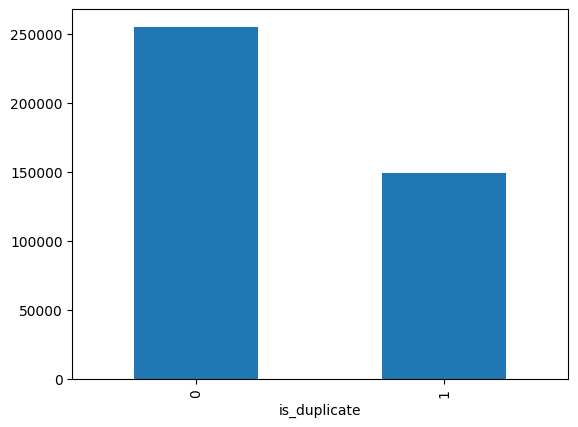

In [5]:
print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')

In [6]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
df = df.sample(40000,random_state=9)

In [8]:
# Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 72415
Number of questions getting repeated 5363


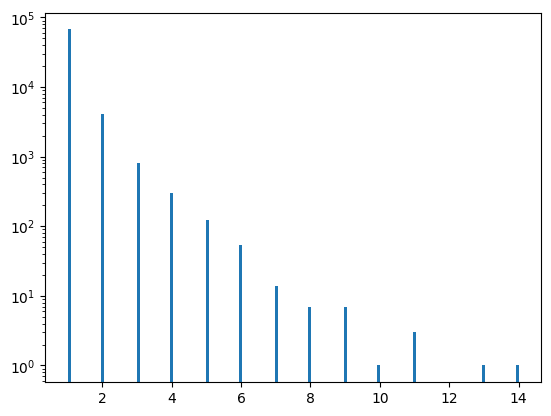

In [9]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=150)
plt.yscale('log')
plt.show()

## **Text Preprocessing**

In [10]:
def preprocess(q):

    q = str(q).lower().strip()


    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')


    q = q.replace('[math]', '')

    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()


    return q

In [11]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

<ipython-input-10-96f0e8c73b40>:158: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)
<ipython-input-10-96f0e8c73b40>:158: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)


In [12]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
358030,358030,28931,487465,what is the difference between a public limite...,what are the differences between private compa...,0
10667,10667,20643,20644,what is the best time table for a student of m...,what is the best time table for student of mat...,1
34474,34474,63158,63159,where can i buy a ti nspire cx cas power cord ...,how many watts does a usb type c cable support,0
388083,388083,520441,520442,why has the thai military junta been strongly ...,how is it that trump has major support from no...,0
51284,51284,90988,90989,how difficult is starting a business in india,how difficult is it to start a new business in...,1


In [13]:
nltk_data_dir = '/content/drive/MyDrive/google colab/project_5_duplicate_question_pairs/nltk_data'

nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('averaged_perceptron_tagger', download_dir=nltk_data_dir)
nltk.download('wordnet', download_dir=nltk_data_dir)

[nltk_data] Downloading package punkt to /content/drive/MyDrive/google
[nltk_data]     colab/project_5_duplicate_question_pairs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /content/drive/MyDrive/google
[nltk_data]     colab/project_5_duplicate_question_pairs/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /content/drive/MyDrive/google
[nltk_data]     colab/project_5_duplicate_question_pairs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
nltk_data_dir = '/content/drive/MyDrive/google colab/project_5_duplicate_question_pairs/nltk_data'

# Add the directory to the NLTK data path
nltk.data.path.append(nltk_data_dir)

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [15]:
lemmatizer = WordNetLemmatizer()

In [16]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [17]:
def lemmatize_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)

    # Tag the tokens with part-of-speech (POS) tags
    tagged_tokens = nltk.pos_tag(tokens)

    # Lemmatize each word using its POS tag
    lemmatized_tokens = []
    for token, pos_tag in tagged_tokens:
        wordnet_pos = get_wordnet_pos(pos_tag) or wordnet.NOUN
        lemmatized_token = lemmatizer.lemmatize(token, pos=wordnet_pos)
        lemmatized_tokens.append(lemmatized_token)

    # Join the lemmatized tokens back into a single string
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [18]:
df['question1'] = df['question1'].apply(lemmatize_text)
df['question2'] = df['question2'].apply(lemmatize_text)

In [19]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
358030,358030,28931,487465,what be the difference between a public limit ...,what be the difference between private company...,0
10667,10667,20643,20644,what be the best time table for a student of m...,what be the best time table for student of mat...,1
34474,34474,63158,63159,where can i buy a ti nspire cx ca power cord u...,how many watt do a usb type c cable support,0
388083,388083,520441,520442,why have the thai military junta be strongly p...,how be it that trump have major support from n...,0
51284,51284,90988,90989,how difficult be start a business in india,how difficult be it to start a new business in...,1


In [20]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

In [21]:
df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
358030,358030,28931,487465,what be the difference between a public limit ...,what be the difference between private company...,0,83,74,14,11
10667,10667,20643,20644,what be the best time table for a student of m...,what be the best time table for student of mat...,1,75,73,16,15
34474,34474,63158,63159,where can i buy a ti nspire cx ca power cord u...,how many watt do a usb type c cable support,0,54,43,13,10
388083,388083,520441,520442,why have the thai military junta be strongly p...,how be it that trump have major support from n...,0,98,126,17,23
51284,51284,90988,90989,how difficult be start a business in india,how difficult be it to start a new business in...,1,42,52,8,11


In [22]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [23]:
df['word_common'] = df.apply(common_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
358030,358030,28931,487465,what be the difference between a public limit ...,what be the difference between private company...,0,83,74,14,11,9
10667,10667,20643,20644,what be the best time table for a student of m...,what be the best time table for student of mat...,1,75,73,16,15,14
34474,34474,63158,63159,where can i buy a ti nspire cx ca power cord u...,how many watt do a usb type c cable support,0,54,43,13,10,3
388083,388083,520441,520442,why have the thai military junta be strongly p...,how be it that trump have major support from n...,0,98,126,17,23,2
51284,51284,90988,90989,how difficult be start a business in india,how difficult be it to start a new business in...,1,42,52,8,11,8


In [24]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return (len(w1) + len(w2))

In [25]:
df['word_total'] = df.apply(total_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
358030,358030,28931,487465,what be the difference between a public limit ...,what be the difference between private company...,0,83,74,14,11,9,21
10667,10667,20643,20644,what be the best time table for a student of m...,what be the best time table for student of mat...,1,75,73,16,15,14,29
34474,34474,63158,63159,where can i buy a ti nspire cx ca power cord u...,how many watt do a usb type c cable support,0,54,43,13,10,3,23
388083,388083,520441,520442,why have the thai military junta be strongly p...,how be it that trump have major support from n...,0,98,126,17,23,2,39
51284,51284,90988,90989,how difficult be start a business in india,how difficult be it to start a new business in...,1,42,52,8,11,8,19


In [26]:
df['word_share'] = round(df['word_common']/df['word_total'],2)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
358030,358030,28931,487465,what be the difference between a public limit ...,what be the difference between private company...,0,83,74,14,11,9,21,0.43
10667,10667,20643,20644,what be the best time table for a student of m...,what be the best time table for student of mat...,1,75,73,16,15,14,29,0.48
34474,34474,63158,63159,where can i buy a ti nspire cx ca power cord u...,how many watt do a usb type c cable support,0,54,43,13,10,3,23,0.13
388083,388083,520441,520442,why have the thai military junta be strongly p...,how be it that trump have major support from n...,0,98,126,17,23,2,39,0.05
51284,51284,90988,90989,how difficult be start a business in india,how difficult be it to start a new business in...,1,42,52,8,11,8,19,0.42


In [27]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
358030,what be the difference between a public limit ...,what be the difference between private company...
10667,what be the best time table for a student of m...,what be the best time table for student of mat...
34474,where can i buy a ti nspire cx ca power cord u...,how many watt do a usb type c cable support
388083,why have the thai military junta be strongly p...,how be it that trump have major support from n...
51284,how difficult be start a business in india,how difficult be it to start a new business in...


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [29]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(40000, 6000)

In [30]:
final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(40000, 8)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
358030,0,83,74,14,11,9,21,0.43
10667,1,75,73,16,15,14,29,0.48
34474,0,54,43,13,10,3,23,0.13
388083,0,98,126,17,23,2,39,0.05
51284,1,42,52,8,11,8,19,0.42


In [31]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(40000, 6008)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,0,1,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
358030,0,83,74,14,11,9,21,0.43,0,0,...,0,0,0,0,0,0,0,0,0,0
10667,1,75,73,16,15,14,29,0.48,0,0,...,0,0,0,0,0,0,0,0,0,0
34474,0,54,43,13,10,3,23,0.13,0,0,...,0,0,0,0,0,0,0,0,0,0
388083,0,98,126,17,23,2,39,0.05,0,0,...,0,0,0,0,0,0,0,0,0,0
51284,1,42,52,8,11,8,19,0.42,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
X = final_df.iloc[:, 1:].values
y = final_df.iloc[:, 0].values

print(X.shape)
print(y.shape)

(40000, 6007)
(40000,)


## **Split Dataset**

In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2,random_state= 9)

## **Random Forest Classifier Model**

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.76725

In [35]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,y_pred)

array([[4621,  487],
       [1375, 1517]])

In [36]:
import pickle

pickle.dump(rf,open('/content/drive/MyDrive/google colab/project_5_duplicate_question_pairs/model/model.pkl','wb'))

In [37]:
pickle.dump(cv,open('/content/drive/MyDrive/google colab/project_5_duplicate_question_pairs/model/cv.pkl','wb'))